In [1]:
!pip install pretty_errors -qU
import pretty_errors
!pip install numpy==1.24.4 -qU

In [2]:
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt

random.seed(0)
np.random.seed(0)

In [3]:
G = nx.erdos_renyi_graph(10, 0.3, seed=1, directed=False)

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


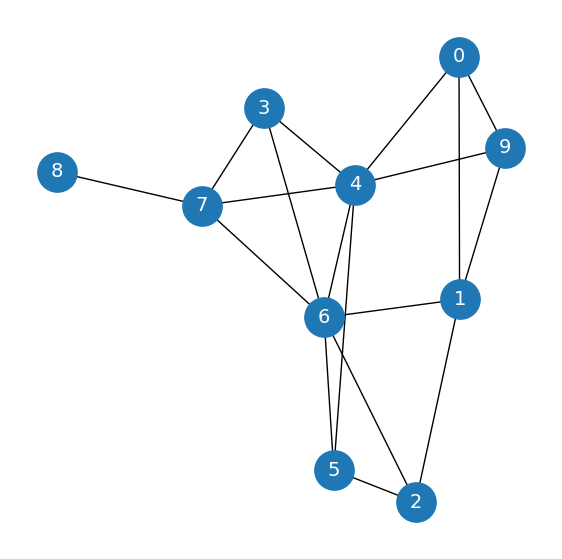

In [4]:
plt.figure(figsize=(7,7))
plt.axis('off')
nx.draw_networkx(G,
                 pos=nx.spring_layout(G, seed=0),
                 #node_color=labels,
                 node_size=800,
                 cmap='coolwarm',
                 font_size=14,
                 font_color='white'
                )

In [5]:
def next_node(previous, current, p, q):
  alphas = []
  neighbors = list(G.neighbors(current))

  for neighbor in neighbors:
    if neighbor == previous:
      alpha = 1/p
    elif G.has_edge(neighbor, previous):
        alpha = 1
    else:
        alpha = 1/q
    alphas.append(alpha)

  probs = [alpha / sum(alphas) for alpha in alphas]
  next = np.random.choice(neighbors, size=1, p=probs)[0]
  return next


def random_walk(start, length, p, q):
  walk = [start]

  for i in range(length):
    current = walk[-1]
    previous = walk[-2] if len(walk) > 1 else None
    next = next_node(previous, current, p, q)
    walk.append(next)

  return walk

In [6]:
random.seed(0)
np.random.seed(0)

random_walk(start=0, length=8, p=1, q=1)

[0, 4, 7, 6, 4, 5, 4, 5, 6]

In [7]:
random.seed(0)
np.random.seed(0)

random_walk(start=0, length=8, p=1, q=10)

[0, 4, 9, 4, 7, 4, 6, 4, 7]

In [8]:
random.seed(0)
np.random.seed(0)

random_walk(start=0, length=8, p=10, q=1)

[0, 4, 7, 6, 3, 4, 7, 6, 5]

## Implementing Node2Vec

In [9]:
!pip install -qU gensim

In [10]:
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [11]:
G = nx.karate_club_graph()

In [12]:
labels = []
for node in G.nodes:
 label = G.nodes[node]['club']
 labels.append(1 if label == 'Officer' else 0)

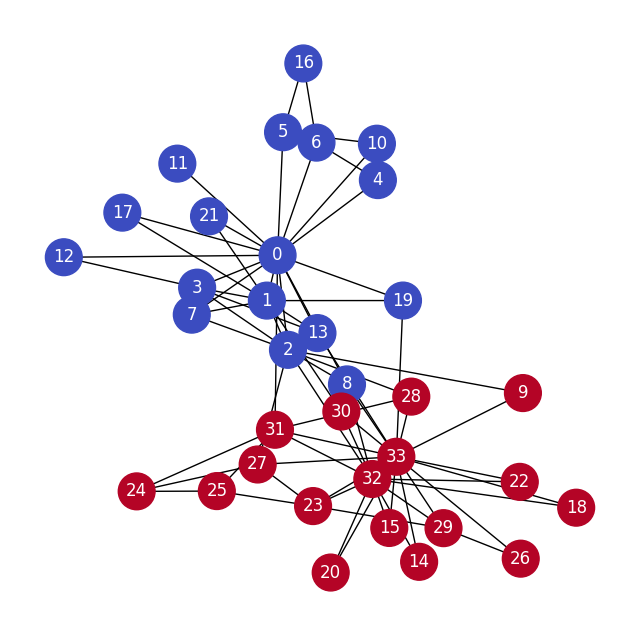

In [13]:
plt.figure(figsize=(8,8))
plt.axis('off')
nx.draw_networkx(G,
                 pos=nx.spring_layout(G, seed=0),
                 node_color=labels,
                 node_size=700,
                 cmap='coolwarm',
                 font_size=12,
                 font_color='white'
                )

In [14]:
walks = []
for node in G.nodes:
  for _ in range(80):
    walks.append(random_walk(node, 10, 3, 2))

In [15]:
node2vec = Word2Vec(walks,
 hs=1, # Hierarchical softmax
 sg=1, # Skip-gram
 vector_size=100,
 window=10,
 workers=2,
 min_count=1,
 seed=0)

In [16]:
node2vec.train(walks,
              total_examples=node2vec.corpus_count,
              epochs=30,
              report_delay=1)

(185825, 897600)

In [17]:
print('Nodes that are the most similar to node 0:')
for similarity in node2vec.wv.most_similar(positive=[0]):
 print(f' {similarity}')

Nodes that are the most similar to node 0:
 (11, 0.70127272605896)
 (1, 0.6546550393104553)
 (6, 0.6500096917152405)
 (21, 0.6318000555038452)
 (10, 0.6288477778434753)
 (16, 0.6167001724243164)
 (17, 0.6086850762367249)
 (5, 0.6072955131530762)
 (4, 0.6037588715553284)
 (3, 0.5947726368904114)


In [18]:
# Similarity between two nodes
print(f"Similarity between node 0 and 4: {node2vec.wv.similarity(0, 4)}")

Similarity between node 0 and 4: 0.6037589907646179


In [19]:
from sklearn.manifold import TSNE

In [20]:
nodes_wv = np.array([node2vec.wv.get_vector(i) for i in range(len(node2vec.wv))])
labels = np.array(labels)

In [21]:
tsne = TSNE(n_components=2,
            learning_rate='auto',
            init='pca',
            random_state=0).fit_transform(nodes_wv)

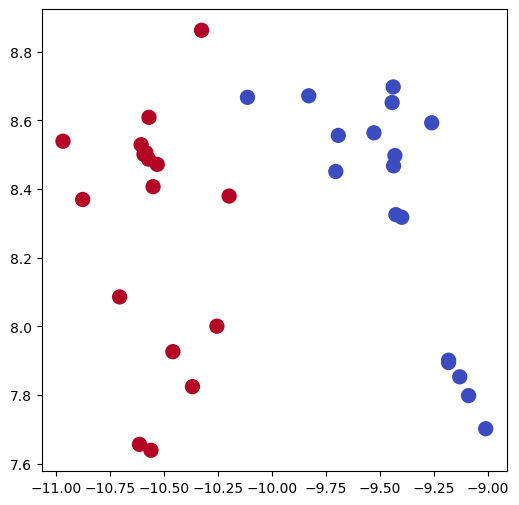

In [22]:
plt.figure(figsize=(6, 6))
plt.scatter(tsne[:, 0], tsne[:, 1], s=100, c=labels, cmap="coolwarm")
plt.show()

In [23]:
len(G.nodes)

34

In [24]:
all_masks = list(np.array(G.nodes))

In [25]:
# shuffle masks
random.shuffle(all_masks)

split_point = int(len(all_masks) * 0.5)

train_mask = all_masks[:split_point]
test_mask = all_masks[split_point:]

print("Shuffled Train Mask:", train_mask)
print("Shuffled Test Mask:", test_mask)

Shuffled Train Mask: [7, 0, 27, 20, 10, 5, 21, 13, 1, 17, 31, 22, 23, 33, 14, 30, 3]
Shuffled Test Mask: [19, 32, 4, 29, 6, 18, 11, 28, 9, 25, 12, 15, 16, 8, 2, 26, 24]


In [26]:
clf = RandomForestClassifier(random_state=0)
clf.fit(nodes_wv[train_mask], labels[train_mask])

RandomForestClassifier(random_state=0)

In [27]:
y_pred = clf.predict(nodes_wv[test_mask])
acc = accuracy_score(y_pred, labels[test_mask])
print(f'Node2Vec accuracy = {acc*100:.2f}%')

Node2Vec accuracy = 94.12%


## GNNs Recommender System - Movie Recommendations

In [28]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

url = 'https://files.grouplens.org/datasets/movielens/ml-100k.zip'

with urlopen(url) as zurl:
  with ZipFile(BytesIO(zurl.read())) as zfile:
    zfile.extractall('.')

In [29]:
import pandas as pd

In [30]:
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'unix_timestamp'])
ratings

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [31]:
movies = pd.read_csv('ml-100k/u.item', sep='|', usecols=range(2), names=['movie_id', 'title'], encoding='latin-1')
movies

,movie_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)
...,...,...
1677,1678,Mat' i syn (1997)
1678,1679,B. Monkey (1998)
1679,1680,Sliding Doors (1998)
1680,1681,You So Crazy (1994)


In [32]:
# Since we want to have movies that are liked by users, we will filter out the movies
# stared 1, 2, and 3 stars to have only 4 and 5 starred movies
ratings = ratings[ratings.rating >= 4]
ratings

,user_id,movie_id,rating,unix_timestamp
5,298,474,4,884182806
7,253,465,5,891628467
11,286,1014,5,879781125
12,200,222,5,876042340
16,122,387,5,879270459
...,...,...,...,...
99988,421,498,4,892241344
99989,495,1091,4,888637503
99990,806,421,4,882388897
99991,676,538,4,892685437


In [33]:
from collections import defaultdict

pairs = defaultdict(int)

# Loop through the entire list of users
for group in ratings.groupby("user_id"):
    # List of IDs of movies rated by the current user
    user_movies = list(group[1]["movie_id"])

    # Count every time two movies are seen together
    for i in range(len(user_movies)):
        for j in range(i+1, len(user_movies)):
            pairs[(user_movies[i], user_movies[j])] += 1

In [34]:
sorted_pairs = sorted(pairs.items(), key=lambda x: x[1], reverse=True)
sorted_pairs[0]

((50, 181), 176)

In [35]:
# Find the rows corresponding to the movies that have been rated together the most often
movies.loc[movies['movie_id'].isin([181, 50])]

,movie_id,title
49,50,Star Wars (1977)
180,181,Return of the Jedi (1983)


In [42]:
sorted_pairs[:5]

[((50, 181), 176),
 ((181, 50), 173),
 ((50, 174), 157),
 ((50, 127), 145),
 ((172, 50), 141)]

In [43]:
movies.loc[movies['movie_id'].isin([50, 181, 174, 127, 172])]

,movie_id,title
49,50,Star Wars (1977)
126,127,"Godfather, The (1972)"
171,172,"Empire Strikes Back, The (1980)"
173,174,Raiders of the Lost Ark (1981)
180,181,Return of the Jedi (1983)


In [36]:
# Create a networkx graph
G = nx.Graph()

# Try to create an edge between movies that are liked together
for pair in pairs:
    movie1, movie2 = pair
    score = pairs[pair]

    # The edge is only created when the score is high enough
    if score >= 20:
        G.add_edge(movie1, movie2, weight=score)

print("Total number of graph nodes:", G.number_of_nodes())
print("Total number of graph edges:", G.number_of_edges())

Total number of graph nodes: 410
Total number of graph edges: 14936


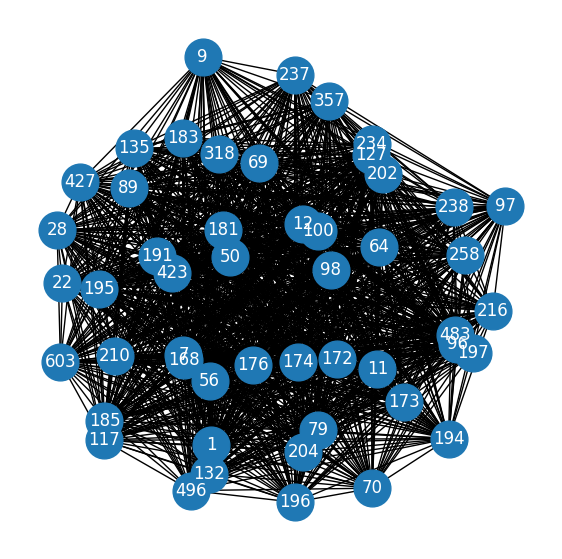

In [48]:
degree_centrality = nx.degree_centrality(G)
sorted_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

top_nodes = [node for node, centrality in sorted_nodes[:50]]

# Visualize subgraph of top 50 nodes
plt.figure(figsize=(7, 7))
plt.axis('off')

# Extract subgraph containing only the top nodes
subgraph = G.subgraph(top_nodes)

# Draw the subgraph
nx.draw_networkx(subgraph,
                 pos=nx.spring_layout(subgraph, seed=0),
                 node_size=700,
                 cmap='coolwarm',
                 font_size=12,
                 font_color='white'
                )

plt.show()


In [60]:
# Calculate the total number of edges within the top 50 nodes
num_top50_edges = sum(G.degree[node] for node in top_nodes) // 2  # Divide by 2 because each edge is counted twice

print(f'Total number of edges within the top 50 nodes: {num_top50_edges}')
print("Total number of graph edges:", G.number_of_edges())
print(f"Ratio of the number of edges in top 50 centrality nodes: {round(num_top50_edges/G.number_of_edges(), 3)*100}%")

Total number of edges within the top 50 nodes: 5718
Total number of graph edges: 14936
Ratio of the number of edges in top 50 centrality nodes: 38.3%


In [37]:
#!pip install node2vec

In [62]:
from node2vec import Node2Vec

node2vec = Node2Vec(G, dimensions=64, walk_length=20, num_walks=200, p=2, q=1, workers=1)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/410 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 200/200 [00:50<00:00,  3.95it/s]


In [39]:
def recommend(movie):
    movie_id = str(movies[movies.title == movie].movie_id.values[0])
    for id in model.wv.most_similar(movie_id)[:5]:
        title = movies[movies.movie_id == int(id[0])].title.values[0]
        print(f'{title}: {id[1]:.2f}')

recommend('Star Wars (1977)')

Return of the Jedi (1983): 0.63
Raiders of the Lost Ark (1981): 0.51
Toy Story (1995): 0.49
Silence of the Lambs, The (1991): 0.46
Monty Python and the Holy Grail (1974): 0.46


In [40]:
recommend('Return of the Jedi (1983)')

Toy Story (1995): 0.73
Star Wars (1977): 0.63
Fugitive, The (1993): 0.62
Empire Strikes Back, The (1980): 0.58
Back to the Future (1985): 0.56


In [61]:
recommend('GoldenEye (1995)')

Return of the Pink Panther, The (1974): 0.64
Maverick (1994): 0.60
Mask, The (1994): 0.60
Tombstone (1993): 0.59
Army of Darkness (1993): 0.59
